It is a problem trying to predict if a user will click on a web page advertisement or not. There are about 40 million rows of data in dataset. It was impossible for my laptop to solve this problem with this size. So i run the model with a randomly subdata from this whole dataset. Mostly 400000 rows. 

There are 21 categorical features in this dataset. 9 of them are hidden by data provider as anonymous categorical features. Others are like device model, device type, app type, site domain etc. 

I used different classification algorthms with a nested-CV approach at the end to see the generalization performance of the models. SGDClassifier, XGBoost and Random Forest are 3 algorithms i tried to get a proper result.

It mostly took hours, even days to train algorithms even with this decreased size of dataset. It may reach up to 24 hours while training, according to the model used. I decided to make some feature engineering to decrease the complexity of problem. 

It is a categorical feature problem which require some encoding, mostly one hot encoding to get results. Some of the features have many unique values, which increases the one-hot-encoded feature size significantly, whih may lead to curse of dimensionality. So i decided to label rare values inside these highly dimensional features as "rare". For 2 engineered columns, it decreased XGBoost to 4 hours, and for 1 engineered column to 8 hours. It was a nice development withut sacrificint accuracy. 

Stochastic Gradient Descent is used in this notebook, which is an efficient and fast algorithm. Eventually it took about 1 hour for this algorithm to get satisfactory results. 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',25)
import random

p = 0.025
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
click = pd.read_csv(r'C:\Users\ali.kilinc\Desktop\CTR Prediction\avazu-ctr-prediction\train\train.csv', 
                    index_col= False, parse_dates = ['hour'], date_parser = parse_date, skiprows = lambda i: i>0 and random.random() > p)

Above code mainly about importing csv file, randomly coosing rows from 40 million dataset. It assigns random values to each row, and skips the rows above that threshold probability. In this example, it is 0.025 which leads to a randomly chosen 1 million dataset. Randomization is required to preserve the distributions inside dataset.

In [2]:
print(click.info())
print(click.describe(include='all'))
print(click.columns)
print(click.head(5))
print(click.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008704 entries, 0 to 1008703
Data columns (total 24 columns):
id                  1008704 non-null uint64
click               1008704 non-null int64
hour                1008704 non-null datetime64[ns]
C1                  1008704 non-null int64
banner_pos          1008704 non-null int64
site_id             1008704 non-null object
site_domain         1008704 non-null object
site_category       1008704 non-null object
app_id              1008704 non-null object
app_domain          1008704 non-null object
app_category        1008704 non-null object
device_id           1008704 non-null object
device_ip           1008704 non-null object
device_model        1008704 non-null object
device_type         1008704 non-null int64
device_conn_type    1008704 non-null int64
C14                 1008704 non-null int64
C15                 1008704 non-null int64
C16                 1008704 non-null int64
C17                 1008704 non-null int64
C18     

In [3]:
click.groupby('click').size().plot(kind = 'bar')

click_through_rate = click['click'].value_counts()/click.shape[0]

print(click_through_rate)
# graph showing the target value distribution, which shows that it is a slghtly unbalanced data(0.82/0.18 rate)

0    0.830157
1    0.169843
Name: click, dtype: float64


In [4]:
click['hour_in_day'] = click['hour'].apply(lambda val : val.hour)

click['weekday'] = click['hour'].apply(lambda val: val.dayofweek)

#click['day_name'] = click['hour'].apply(lambda x: x.strftime('%A'))
# Hour feature is divided into various features that may be beneficial if analyzed seperately like weekday and hour in day.

In [5]:
click = click.drop(['id', 'hour', 'device_id', 'device_ip'], axis = 1)

print(click.columns)

Y = click.iloc[:,:1]
ycol = click.columns[:1]
df_y = pd.DataFrame(Y, columns = ycol)

X = click.drop(['click'], axis = 1)
xcol = click.columns[1:]
df_x = pd.DataFrame(X, columns = xcol)

#Some of the features whch are too personal are eliminated initially. ID, device ID, and Device IP are too special values to analyze
#Also hour feature is eliminated because it is divided into seperate features

Index(['click', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_model', 'device_type',
       'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'hour_in_day', 'weekday'],
      dtype='object')


In [6]:
unique_counts = pd.DataFrame.from_records([(col, df_x[col].nunique()) for col in df_x.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
print(unique_counts)

fix_cols = []
for col in df_x.columns:
    if df_x[col].nunique() == 1:
        fix_cols.append(col)
    else:
        pass

emp_cols = []
for col in df_x.columns:
    if df_x[col].count() > 0:
        pass
    else:
        emp_cols.append(col)
        
df_x.drop(list(emp_cols+fix_cols))

for col in df_x.columns:
    df_x[col] = df_x[col].astype('category')

#Empty and fix columns are eliminated with above code. Also we see the unique values for each features, to see which features 
# may lead us to curse of dimensionality. Some feature engineering may be needed afterwards. 
#In this first model, I havent used any feature engineering. 

         Column_Name  Num_Unique
10  device_conn_type           4
15               C18           4
9        device_type           5
0                 C1           7
20           weekday           7
1         banner_pos           7
12               C15           8
13               C16           9
4      site_category          20
19       hour_in_day          24
7       app_category          26
18               C21          60
16               C19          66
17               C20         163
6         app_domain         200
14               C17         421
11               C14        2231
2            site_id        2648
3        site_domain        2847
5             app_id        3158
8       device_model        5199


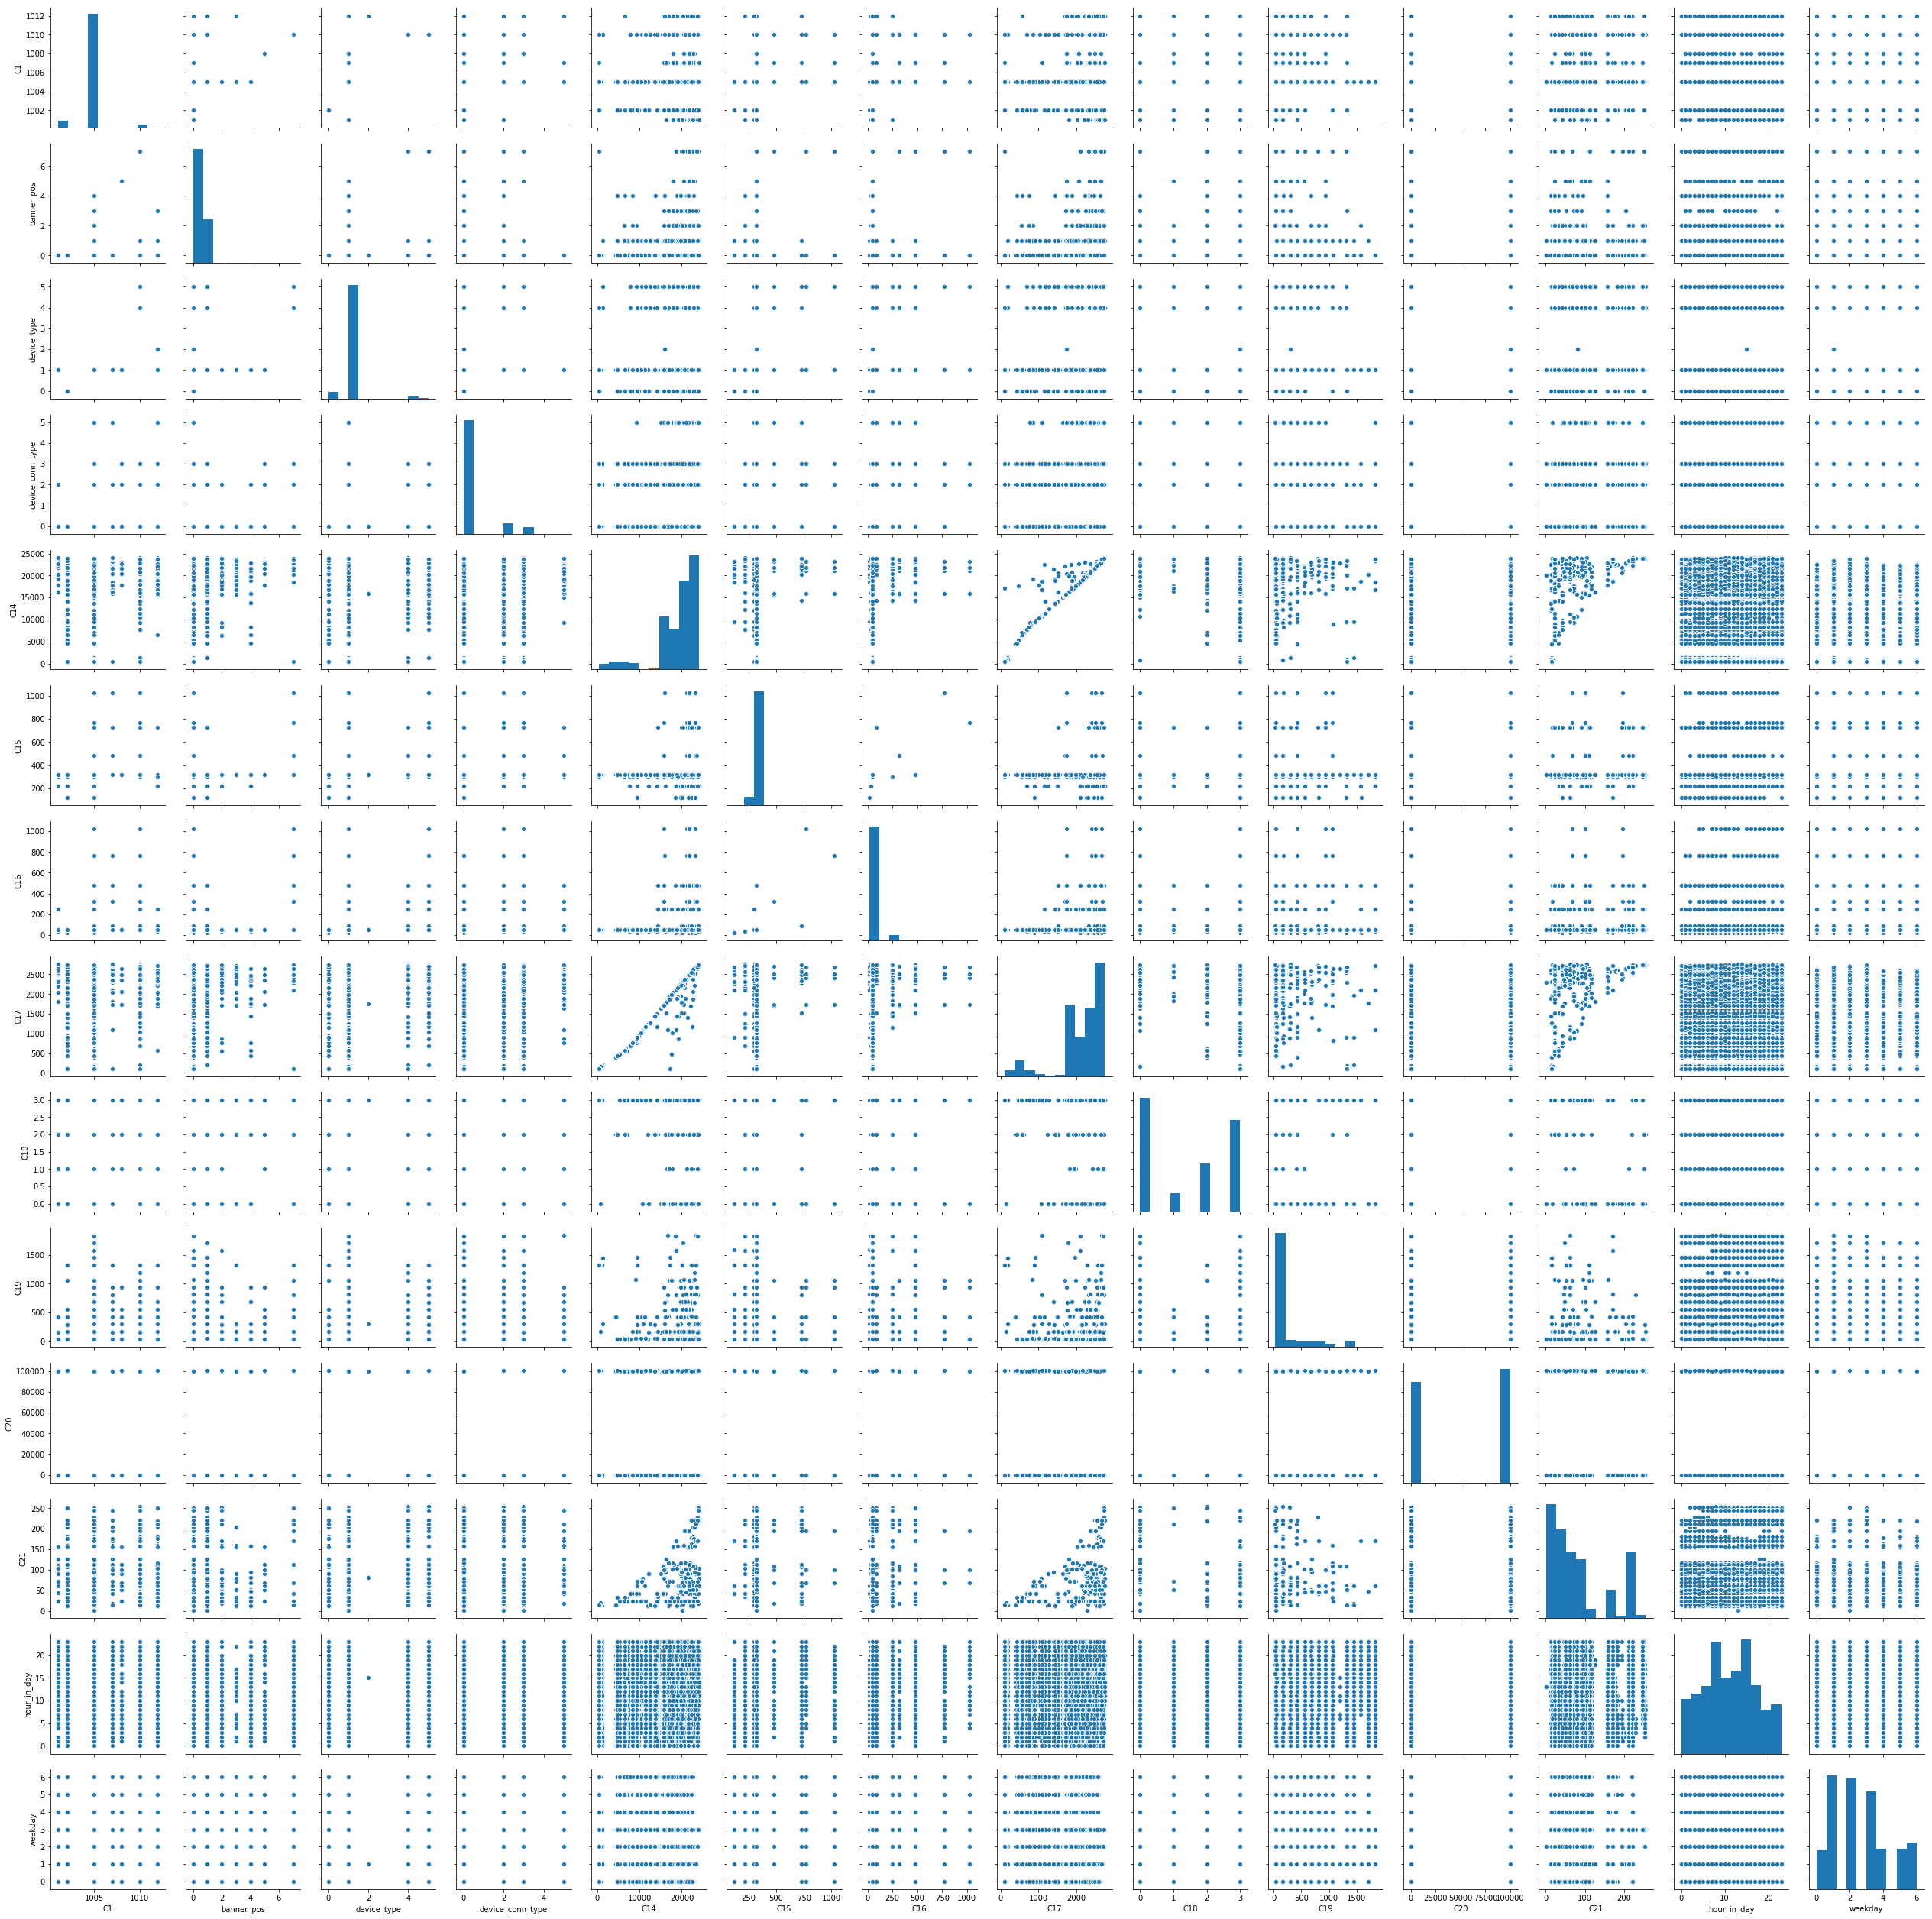

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_x)

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, CategoricalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [9]:
import timeit
start_time = timeit.default_timer()


sgd = SGDClassifier(loss = 'log', fit_intercept= True, verbose = 0, tol = 1e-3, learning_rate = 'optimal')

params = {
        'penalty':['l1','l2','elasticnet'],
        'max_iter': np.linspace(100,700,3,endpoint = True),
        'alpha': np.linspace(0.0001, 0.0001, 1, endpoint=True),
        'n_iter_no_change':np.linspace(5, 17, 3, endpoint=True)
        }

grid_search = GridSearchCV(pipe, params, cv=3, verbose=1)

pipe = make_pipeline(OneHotEncoder(sparse = True, handle_unknown='ignore'), sgd)

cv = StratifiedKFold(n_splits = 5, random_state = 23, shuffle = False)

roc_auc = cross_val_score(pipe, df_x, df_y.values.ravel(), scoring = 'roc_auc', cv=cv)
accuracy = cross_val_score(pipe, df_x, df_y.values.ravel(), scoring = 'accuracy', cv=cv)


print("roc_auc = {}, accuracy = {}".format(np.mean(roc_auc),np.mean(accuracy)))
print("---%0.1f minutes---" %((timeit.default_timer()-start_time)/60))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.1min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.2min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.2min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.3min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.6min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.3min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.2min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.1min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.2min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  6.0min finished


roc_auc = 0.6706960577359047, accuracy = 0.7799691999114582
---64.5 minutes---
